# Introduction to LCEL and LangGraph: LangChain Powered RAG

In the following notebook we're going to focus on learning how to navigate and build useful applications using LangChain, specifically LCEL, and how to integrate different APIs together into a coherent RAG application!

In the notebook, you'll complete the following Tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables  
  3. Initialize a Simple Chain using LCEL
  4. Implement Naive RAG using LCEL
  5. Implement Simple RAG using LCEL

- 🤝 Breakout Room #2:
  1. Install LangGraph
  2. Understanding States and Nodes
  3. Building a Basic Graph
  4. Implementing a Simple RAG Graph
  5. Extending the Graph with Complex Flows

Let's get started!



# 🤝 Breakout Room #1

##  Installing Required Libraries

One of the [key features](https://blog.langchain.dev/langchain-v02-leap-to-stability/) of LangChain v0.2.0 is the compartmentalization of the various LangChain ecosystem packages and added stability.

Instead of one all encompassing Python package - LangChain has a `core` package and a number of additional supplementary packages.

We'll start by grabbing all of our LangChain related packages!

In [ ]:
!pip install -qU langchain==0.3.15 langchain-core==0.3.31 langchain-community==0.3.15 langchain-openai==0.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.1 MB/s eta 0:00:00


Now we can get our Qdrant dependencies!

In [ ]:
!pip install -qU langchain-qdrant==0.2.0 qdrant-client==1.13.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.6/306.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 25.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.3 which is incompatible.


Let's finally get `tiktoken` and `pymupdf` so we can leverage them later on!

In [ ]:
!pip install -qU tiktoken pymupdf==1.25.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 98.4 MB/s eta 0:00:00


## Set Environment Variables

We'll be leveraging OpenAI's suite of APIs - so we'll set our `OPENAI_API_KEY` `env` variable here!

In [ ]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


## Initialize a Simple Chain using LCEL

The first thing we'll do is familiarize ourselves with LCEL and the specific ins and outs of how we can use it!

### LLM Orchestration Tool (LangChain)

Let's dive right into [LangChain](https://www.langchain.com/)!

The first thing we want to do is create an object that lets us access OpenAI's `gpt-4o` model.

In [ ]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4o-mini")

####❓ Question #1:

What other models could we use, and how would the above code change?

> HINT: Check out [this page](https://python.langchain.com/docs/integrations/chat/) to find the answer!

#### Answer #1

There are other models like Mistral, Anthropic, Deepseek...
To use Anthropic by example we must use his provider and choose one of his models:

```
from langchain_anthropic import ChatAnthropic  
model = ChatAnthropic(model="claude-3-opus")
```



### Prompt Template

Now, we'll set up a prompt template - more specifically a `ChatPromptTemplate`. This will let us build a prompt we can modify when we call our LLM!

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

system_template = "You are a legendary and mythical Wizard. You speak in riddles and make obscure and pun-filled references to exotic cheeses."
human_template = "{content}"

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", system_template),
    ("human", human_template)
])

### Our First Chain

Now we can set up our first chain!

A chain is simply two components that feed directly into eachother in a sequential fashion!

You'll notice that we're using the pipe operator `|` to connect our `chat_prompt` to our `llm`.

This is a simplified method of creating chains and it leverages the LangChain Expression Language, or LCEL.

You can read more about it [here](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel), but there a few features we should be aware of out of the box (taken directly from LangChain's documentation linked above):

- **Async, Batch, and Streaming Support** Any chain constructed this way will automatically have full sync, async, batch, and streaming support. This makes it easy to prototype a chain in a Jupyter notebook using the sync interface, and then expose it as an async streaming interface.

- **Fallbacks** The non-determinism of LLMs makes it important to be able to handle errors gracefully. With LCEL you can easily attach fallbacks to any chain.

- **Parallelism** Since LLM applications involve (sometimes long) API calls, it often becomes important to run things in parallel. With LCEL syntax, any components that can be run in parallel automatically are.

In the following code cell we have two components:

- `chat_prompt`, which is a formattable `ChatPromptTemplate` that contains a system message and a human message.
- `openai_chat_model`, which is a LangChain Runnable wrapped OpenAI client.

We'd like to be able to pass our own `content` (as found in our `human_template`) and then have the resulting message pair sent to our model and responded to!

In [ ]:
chain = chat_prompt | openai_chat_model

Notice the pattern here:

We invoke our chain with the `dict` `{"content" : "Hello world!"}`.

It enters our chain:

`{"content" : "Hello world!"}` -> `invoke()` -> `chat_prompt`

Our `chat_prompt` returns a `PromptValue`, which is the formatted prompt. We then "pipe" the output of our `chat_prompt` into our `llm`.

`PromptValue` -> `|` -> `llm`

Our `llm` then takes the list of messages and provides an output which is return as a `str`!







In [ ]:
print(chain.invoke({"content": "Hello world!"}))

content='Ah, greetings to thee, a traveler bold upon this digital cheese board! Speak your query, and like a fine Roquefort, I shall crumble into answers, rich and blue with wisdom. What savory conundrum dost thou seek to unravel in this wheel of existence?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 38, 'total_tokens': 95, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None} id='run-b597a7ba-eff9-4870-a219-60656c35b157-0' usage_metadata={'input_tokens': 38, 'output_tokens': 57, 'total_tokens': 95, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


Let's try it out with a different prompt!

In [ ]:
chain.invoke({"content" : "Could I please have some advice on how to become a better Python Programmer?"})

AIMessage(content='Ah, seeker of the digital arts! To weave with Python’s serpentine grace, one must first partake in a feast of knowledge, much like savoring a creamy Brie en Croûte paired with a crisp apple.\n\n**1. Curds of Curiosity:** Like a fine Roquefort, pungent with complexity, delve into the depths of frameworks and libraries. Grip thy mind with Django, Flask, or NumPy—each a layer of flavor in the cheeseboard of programming!\n\n**2. Experimentation, the Blue Cheese Path:** Similar to an adventurous pairing of Gorgonzola with honey, allow thyself to explore. Craft small projects, let thy creativity run wild, and taste the trials and tribulations, for even a moldy Brie can lead to layered brilliance in code.\n\n**3. Community, the Fondue of Friendship:** Dip thy spoon of experience into the bubbling pot of learning! Engage in forums, attend meetups, and share notes—much like sharing a wheel of Camembert, for together, you shall melt in the warmth of collaboration.\n\n**4. Read

Notice how we specifically referenced our `content` format option!

Now that we have the basics set up - let's see what we mean by "Retrieval Augmented" Generation.

## Naive RAG - Manually adding context through the Prompt Template

Let's look at how our model performs at a simple task - defining what LangChain is!

We'll redo some of our previous work to change the `system_template` to be less...verbose.

In [ ]:
system_template = "You are a helpful assistant."
human_template = "{content}"

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", system_template),
    ("human", human_template)
])

chat_chain = chat_prompt | openai_chat_model ### LCEL Chain!

print(chat_chain.invoke({"content" : "Please define LangGraph."}))

content='As of my last knowledge update in October 2023, "LangGraph" does not refer to a widely recognized term, concept, or technology in the fields of linguistics, programming, or graph theory. It\'s possible that it may refer to a specific tool, library, or framework that has emerged after my last update, or it could be a term used in a niche research area or project.\n\nIf you can provide additional context or specify the domain in which "LangGraph" is used, I\'d be happy to help clarify or provide related information!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 111, 'prompt_tokens': 22, 'total_tokens': 133, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None} id=

Well, that's not very good - is it!

The issue at play here is that our model was not trained on the idea of "LangChain", and so it's left with nothing but a guess - definitely not what we want the answer to be!

Let's ask another simple LangChain question!

In [ ]:
print(chat_chain.invoke({"content" : "What is LangChain Expression Language (LECL)?"}))

content='LangChain Expression Language (LECL) is a domain-specific language designed to enhance the functionality of applications built using the LangChain framework. LangChain itself is a framework designed to build applications that leverage large language models (LLMs), and LECL serves as a way to create more complex and dynamic interactions with these models.\n\nLECL allows developers to express computations, transformations, and queries in a concise and readable format specific to the capabilities of LLMs. It aims to simplify the manipulation of data and instructions given to the language model, making it easier to implement custom logic and data processing workflows within applications.\n\nKey features of LECL include:\n\n1. **Simplicity**: It is designed for ease of use, aiming to be easily understandable for developers working with LLMs.\n\n2. **Integration with LangChain**: It works seamlessly within the LangChain framework, allowing users to leverage its capabilities when con

While it provides a confident response, that response is entirely ficticious! Not a great look, OpenAI!

However, let's see what happens when we rework our prompts - and we add the content from the docs to our prompt as context.

In [ ]:
HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context response with "I don't know"
"""

CONTEXT = """
LangChain Expression Language or LCEL is a declarative way to easily compose chains together. There are several benefits to writing chains in this manner (as opposed to writing normal code):

Async, Batch, and Streaming Support Any chain constructed this way will automatically have full sync, async, batch, and streaming support. This makes it easy to prototype a chain in a Jupyter notebook using the sync interface, and then expose it as an async streaming interface.

Fallbacks The non-determinism of LLMs makes it important to be able to handle errors gracefully. With LCEL you can easily attach fallbacks to any chain.

Parallelism Since LLM applications involve (sometimes long) API calls, it often becomes important to run things in parallel. With LCEL syntax, any components that can be run in parallel automatically are.

Seamless LangSmith Tracing Integration As your chains get more and more complex, it becomes increasingly important to understand what exactly is happening at every step. With LCEL, all steps are automatically logged to LangSmith for maximal observability and debuggability.
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

chat_chain = chat_prompt | openai_chat_model

print(chat_chain.invoke({"query" : "What is LangChain Expression Language?", "context" : CONTEXT}))

content='LangChain Expression Language (LCEL) is a declarative way to compose chains together, offering several benefits such as async, batch, and streaming support, easy attachment of fallbacks for error handling, automatic parallelism for components, and seamless integration with LangSmith for tracing and observability of complex chains.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 282, 'total_tokens': 344, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None} id='run-b16f4a3c-f5d9-4272-84a0-8625737b7e7e-0' usage_metadata={'input_tokens': 282, 'output_tokens': 62, 'total_tokens': 344, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_t

You'll notice that the response is much better this time. Not only does it answer the question well - but there's no trace of confabulation (hallucination) at all!

> NOTE: While RAG is an effective strategy to *help* ground LLMs, it is not nearly 100% effective. You will still need to ensure your responses are factual through some other processes

That, in essence, is the idea of RAG. We provide the model with context to answer our queries - and rely on it to translate the potentially lengthy and difficult to parse context into a natural language answer!

However, manually providing context is not scalable - and doesn't really offer any benefit.

Enter: Retrieval Pipelines.

## Implement Simple RAG using LCEL

Now we can make a RAG application that will help us bridge the gap between our Pythonic implementation and a fully LangChain powered solution!

## Putting the R in RAG: Retrieval 101

In order to make our RAG system useful, we need a way to provide context that is most likely to answer our user's query to the LLM as additional context.

Let's tackle an immediate problem first: The Context Window.

All (most) LLMs have a limited context window which is typically measured in tokens. This window is an upper bound of how much stuff we can stuff in the model's input at a time.

Let's say we want to work off of a relatively large piece of source data - like the Ultimate Hitchhiker's Guide to the Galaxy. All 898 pages of it!

> NOTE: It is recommended you do not run the following cells, they are purely for demonstrative purposes.

In [ ]:
context = """
EVERY HITCHHIKER'S GUIDE BOOK
"""

We can leverage our tokenizer to count the number of tokens for us!

In [ ]:
import tiktoken

enc = tiktoken.encoding_for_model("gpt-4o")

In [ ]:
len(enc.encode(context))

636144

The full set comes in at a whopping *636,144* tokens.

So, we have too much context. What can we do?

Well, the first thing that might enter your mind is: "Use a model with more context window", and we could definitely do that! However, even `gpt-4-128k` wouldn't be able to fit that whole text in the context window at once.

So, we can try splitting our document up into little pieces - that way, we can avoid providing too much context.

We have another problem now.

If we split our document up into little pieces, and we can't put all of them in the prompt. How do we decide which to include in the prompt?!

> NOTE: Content splitting/chunking strategies are an active area of research and iterative developement. There is no "one size fits all" approach to chunking/splitting at this moment. Use your best judgement to determine chunking strategies!

In order to conceptualize the following processes - let's create a toy context set!

### TextSplitting aka Chunking

We'll use the `RecursiveCharacterTextSplitter` to create our toy example.

It will split based on the following rules:

- Each chunk has a maximum size of 100 tokens
- It will try and split first on the `\n\n` character, then on the `\n`, then on the `<SPACE>` character, and finally it will split on individual tokens.

Let's implement it and see the results!

In [ ]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o-mini").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 100,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

In [ ]:
chunks = text_splitter.split_text(CONTEXT)

In [ ]:
len(chunks)

3

In [ ]:
for chunk in chunks:
  print(chunk)
  print("----")

LangChain Expression Language or LCEL is a declarative way to easily compose chains together. There are several benefits to writing chains in this manner (as opposed to writing normal code):

Async, Batch, and Streaming Support Any chain constructed this way will automatically have full sync, async, batch, and streaming support. This makes it easy to prototype a chain in a Jupyter notebook using the sync interface, and then expose it as an async streaming interface.
----
Fallbacks The non-determinism of LLMs makes it important to be able to handle errors gracefully. With LCEL you can easily attach fallbacks to any chain.

Parallelism Since LLM applications involve (sometimes long) API calls, it often becomes important to run things in parallel. With LCEL syntax, any components that can be run in parallel automatically are.
----
Seamless LangSmith Tracing Integration As your chains get more and more complex, it becomes increasingly important to understand what exactly is happening at ev

As is shown in our result, we've split each section into 100 token chunks - cleanly separated by `\n\n` characters!

####🏗️ Activity #1:

While there's nothing specifically wrong with the chunking method used above - it is a naive approach that is not sensitive to specific data formats.

Brainstorm some ideas that would split large single documents into smaller documents.

1. Split based on the format of the file
2. Split based on punctuations
3. Slit based on deep undrstanding of the text

## Embeddings and Dense Vector Search

Now that we have our individual chunks, we need a system to correctly select the relevant pieces of information to answer our query.

This sounds like a perfect job for embeddings!

We'll be using OpenAI's `text-embedding-3` model as our embedding model today!

Let's load it up through LangChain.

In [ ]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

####❓ Question #2:

What is the embedding dimension, given that we're using `text-embedding-3-small`?

You will need to fill the next cell out correctly with your embedding dimension for the rest of the notebook to run.

> HINT: Check out the [docs](https://platform.openai.com/docs/guides/embeddings) to help you answer this question.

In [ ]:
embedding_dim =  1536

### Using A Vector Database - Intoduction to Qdrant

Up to this point, we've been using a dictionary to hold our embeddings - typically, we'll want to use a more robust strategy.

In this bootcamp - we'll be focusing on leveraging [Qdrant's vector database](https://qdrant.tech/qdrant-vector-database/).

Let's take a look at how we set-up Qdrant!

> NOTE: We'll be spending a lot of time learning about Qdrant throughout the remainder of our time together - but for an initial primer, please check out [this resource](https://qdrant.tech/articles/what-is-a-vector-database/)

We are going to be using an "in-memory" Qdrant client, which means that our vectors will be held in our system's memory (RAM) - this is useful for prototyping and developement at smaller scales - but would need to be modified when moving to production. Luckily for us, this modification is trivial!

> NOTE: While LangChain uses the terminology "VectorStore" (also known as a Vector Library), Qdrant is a "Vector Database" - more info. on that [here](https://weaviate.io/blog/vector-library-vs-vector-database).

In [ ]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

Next, we need to create a collection - a collection is a specific...collection of vectors within the Qdrant client.

These are useful as they allow us to create multiple different "warehouses" in a single client, which can be leveraged for personalization and more!

Also notice that we define what our vector shapes are (embedding dim) as well as our desired distance metric.

In [ ]:
client.create_collection(
    collection_name="lcel_doc_v1",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE),
)

True

Now we can assemble our vector database! Notice that we provide our client, our created collection, and our embedding model!

In [ ]:
vector_store = QdrantVectorStore(
    client=client,
    collection_name="lcel_doc_v1",
    embedding=embedding_model,
)

Now that we have our vector database set-up

In [ ]:
_ = vector_store.add_texts(texts=chunks)

### Creating a Retriever

Now that we have an idea of how we're getting our most relevant information - let's see how we could create a pipeline that would automatically extract the closest chunk to our query and use it as context for our prompt!

This will involve a popular LangChain interace known as `as_retriever`!

> NOTE: We can still specify how many documents we wish to retrieve per vector.

In [ ]:
retriever = vector_store.as_retriever(search_kwargs={"k": 2})

## Bringing it All Together

Now that we have our Retriever, our promt Augmentation, and our Generator - we're ready to create a simple RAG chain using LCEL!

This chain does the following things:

1. It takes in some `str` and passes it to two different LCEL Runnables:
  - `retriever`, which takes the string and calls `retrieve` on it - passing the output (formatted as a list) to the `dict` under the key `context`
  - `RunnablePassthrough()` which simply propogates the `str` to the `dict` under the key `query`.
2. It chains the `dict` to format the `chat_prompt` which expects both a `query` and `context`
3. It chains the resulting message to the LLM, and calls it - returning a full response
4. That response is chained to the `StrOutputParser()` which converts the response blob into a `str` containing the content of the response!

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

simple_rag  = (
    {"context": retriever, "query": RunnablePassthrough()}
    | chat_prompt
    | openai_chat_model
    | StrOutputParser()
)

In [ ]:
simple_rag.invoke("What is LCEL?")

'LCEL, or LangChain Expression Language, is a declarative way to easily compose chains together. It offers several advantages over traditional coding methods, including full sync, async, batch, and streaming support. This allows for easy prototyping in environments like Jupyter notebooks, while also enabling the exposure of chains as async streaming interfaces. Additionally, LCEL facilitates the handling of errors through fallbacks and supports parallel execution of components, which is particularly useful in applications involving potentially lengthy API calls.'

####❓ Question #3:

What does LCEL do that makes it more reliable at scale?

> HINT: Use your newly created `simple_rag` to help you answer this question!

### Answer 3
LCEL offers an unique entry point for our prompt message. It also propagate the prompt to the runnables and offers many utilies like error handling , async and streaming support natively

### A Note On Runnables

# Understanding LangChain Runnables and LCEL

In LangChain, a Runnable is like a LEGO brick in your AI application - it's a standardized component that can be easily connected with other components. The real power of Runnables comes from their ability to be combined in flexible ways using LCEL (LangChain Expression Language).

## Key Features of Runnables

### 1. Universal Interface
Every Runnable in LangChain follows the same pattern:
- Takes an input
- Performs some operation
- Returns an output

This consistency means you can treat different components (like models, retrievers, or parsers) in the same way.

### 2. Built-in Parallelization
Runnables come with methods for handling multiple inputs efficiently:
```python
# Process inputs in parallel, maintain order
results = chain.batch([input1, input2, input3])

# Process inputs as they complete
for result in chain.batch_as_completed([input1, input2, input3]):
    print(result)
```

### 3. Streaming Support
Perfect for responsive applications:
```python
# Stream outputs as they're generated
for chunk in chain.stream({"query": "Tell me a story"}):
    print(chunk, end="", flush=True)
```

### 4. Easy Composition
The `|` operator makes building pipelines intuitive:
```python
# Create a basic RAG chain
rag_chain = retriever | prompt | model | output_parser
```

## Common Types of Runnables

- **Language Models**: Like our `ChatOpenAI` instance
- **Prompt Templates**: Format inputs consistently
- **Retrievers**: Get relevant context from a vector store
- **Output Parsers**: Structure model outputs
- **LangGraph Nodes**: Individual components in our graph

Think of Runnables as the building blocks of your LLM application. Just like how you can combine LEGO bricks in countless ways, you can mix and match Runnables to create increasingly sophisticated applications!



# 🤝 Breakout Room #2

## LangGraph Based RAG

Now that we have a reasonable grasp of LCEL and the idea of Runnables - let's see how we can use LangGraph to build the same system!

### Primer: What is LangGraph?
LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

#### Why Cycles?
In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

#### Why LangGraph?
Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

> NOTE: We're going to focus on building a simple DAG for today's assignment as an introduction to LangGraph

In [ ]:
!pip install -qU langgraph

### Putting the State in Stateful

Earlier we used this phrasing:

> coordinated multi-actor and stateful applications

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

However, in our example here, we're focusing on a simpler `State` object:

```python
class State(TypedDict):
    question: str
    context: List[Document]
    response: str
```

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. **We initialize our state object**:
   ```python
   {
       "question": "",
       "context": [],
       "response": ""
   }
   ```

2. **Our user submits a query to our application.**  
   We store the user's question in `state["question"]`. Now we have:
   ```python
   {
       "question": "How tall is the Eiffel Tower?",
       "context": [],
       "response": ""
   }
   ```

3. **We pass our state object to an Agent node** which is able to read the current state. It will use the value of `state["question"]` as input and might retrieve some context documents related to the question. It then generates a response which it stores in `state["response"]`. For example:
   ```python
   {
       "question": "How tall is the Eiffel Tower?",
       "context": [Document(page_content="...some data...")],
       "response": "The Eiffel Tower is about 324 meters tall..."
   }
   ```

That's it! The important part is that we have a consistent object (`State`) that's passed around, holding the crucial information as we go from one node to the next. This ensures our application has a single source of truth about what has happened so far and what is happening now.



In [ ]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL Runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".  

### Building Nodes

We're going to need two nodes:

A node for retrieval, and a node for generation.

Let's start with our `retrieve` node!

Notice how we do not need to update the state object in the node, but can instead return a modification directly to our state.

In [ ]:
def retrieve(state: State) -> State:
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

Next, let's create our `generate` node - which will leverage some LCEL!

In [ ]:
def generate(state: State) -> State:
  generation_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generation_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

Now we can start defining our graph!

Think of the graph's state as a blank canvas that we can add nodes and edges to.

Every graph starts with two special nodes - START and END - the act as the entry and exit point to the other nodes in the graphs.  

All valid graphs must start at the START node and end at the END node.

In [ ]:
# Start with the blank canvas
graph_builder = StateGraph(State)

Now we can add a sequence to our "canvas" (graph) - this can be done by providing a list of nodes, the will automatically have edges that connect the i-th element to the i+1-th element in the list. The final element will be added to the END node unless otherwise specified.

In [ ]:
graph_builder = graph_builder.add_sequence([retrieve, generate])

Next, let's connect our START node to our `retrieve` node by adding an edge.

In [ ]:
graph_builder.add_edge(START, "retrieve")

Finally we can compile our graph! This will do basic verification to ensure that the Runnables have the correct inputs/outputs and can be matched.

In [ ]:
graph = graph_builder.compile()

Finally, we can visualize our graph!

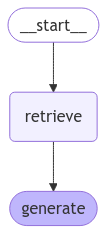

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

Let's take it for a spin!

We invoke our graph like we do any other Runnable in LCEL!

> NOTE: That's right, even a compiled graph is a Runnable!

In [ ]:
response = graph.invoke({"question" : "How does LCEL work?"})
response["response"]

'LCEL, or LangChain Expression Language, works as a declarative way to compose chains together. It offers several benefits, including:\n\n1. **Async, Batch, and Streaming Support**: Chains constructed using LCEL automatically have full support for synchronous, asynchronous, batch, and streaming interfaces. This makes it easy to prototype a chain in a Jupyter notebook with synchronous behavior and then transition to an asynchronous streaming interface.\n\n2. **Fallbacks**: Due to the non-determinism of LLMs (Large Language Models), LCEL allows for easy attachment of fallbacks to any chain, which helps in handling errors gracefully.\n\n3. **Parallelism**: LCEL syntax enables components that can be executed in parallel to do so automatically, which is important as LLM applications often involve long API calls.\n\nOverall, LCEL streamlines the process of building robust and efficient chains for LLM applications.'

In [ ]:
response = graph.invoke({"question" : "Who is Batman?"})
response["response"]

"I don't know."

#### ❓ Question #4:
LangGraph's graph-based approach lets us visualize and manage complex flows naturally. How could we extend our current implementation to handle edge cases? For example:
- What if the retriever finds no relevant context?  
Answer : I can add a node in the graph which will make him search look for context somewhre else
- What if the response needs fact-checking?
Answer : I can add a node and use a fact check API
